# Demo: Processing and interpreting magnetic data

This is an outline of the live demo that I'll give at the presentation. 
We'll use some aeromagnetic total field anomaly data from Brazil. 

The goal is demostrate what can currently be done in [Fatiando a Terra](http://fatiando.org/).
We'll use a few methods that aren't usually available in comercial software, like the Equivalent Layer method, a method for estimating the direction of magnetization, and reduction to the pole with remanent magnetization.

## Loading the data from a text file

I'll use the numpy library for loading the data and matplotlib for visualizing it in a map.

In [1]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
xp, yp, zp, topo, data = np.loadtxt('mag-data.txt', unpack=True)
inc = -19.5
dec = -18.5

Quickly plot this in a map to see how the data points are distributed and what height was the aquisition.

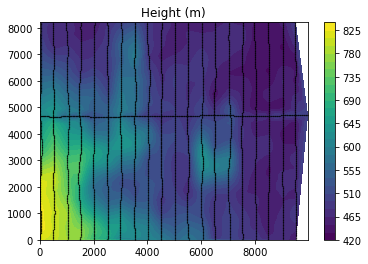

In [3]:
plt.title('Height (m)')
plt.tricontourf(yp, xp, -zp, 30)
plt.colorbar()
plt.plot(yp, xp, '.k', markersize=0.5)

Plot the topography.

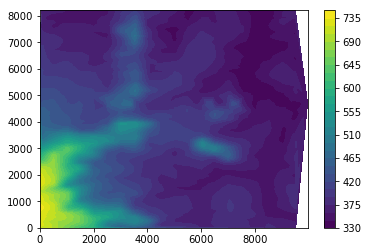

In [4]:
plt.tricontourf(yp, xp, topo, 30)
plt.colorbar()

And the magnetic total field anomaly.

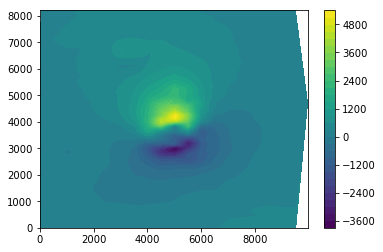

In [5]:
plt.tricontourf(yp, xp, data, 30)
plt.colorbar()

## Gridding and leveling

The problem with this dataset is that it's not on a regular grid (so we can't use any processing with the Fourier transform) and the points aren't all on the same height. So changes in the anomaly can be due to a height difference instead of a difference in the underlying source. Before we can go on processing, we must fix this. 

Thankfully, Fatiando implements a method called the Equivalent Layer which lets us calculate the anomaly anywhere we want. The ideia is that we estimate a magnetization distribution on a layer that fits our observed anomaly (an inversion). Then, thanks to potential field theory, we can use this "equivalent layer" to forward model the anomaly on any point we want, for example on a regular grid with uniform height.

First, we load the required modules from Fatiando.
We'll need to use regularization for this inversion. 
A simple damping will be enough.

In [6]:
from fatiando.gravmag.eqlayer import EQLTotalField
from fatiando.inversion import Damping
from fatiando.mesher import PointGrid

/home/leo/bin/anaconda/envs/tgif-demo/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


Create our layer of point masses below the data.

In [7]:
area = [xp.min(), xp.max(), yp.min(), yp.max()]
layer = PointGrid(area, z=-100, shape=(80, 80))

Make the data misfit and regularization objects.

In [8]:
misfit = EQLTotalField(xp, yp, zp, data, inc, dec, layer)
regul = Damping(misfit.nparams)

Combine them with a small regularization parameter (I knew beforehand that this would work).

In [9]:
eql = misfit + 1e-12*regul

Fit the layer to our data.

In [10]:
%%time
eql.fit()

CPU times: user 31.3 s, sys: 1.34 s, total: 32.7 s
Wall time: 19 s


And we get estimated magnetization intensity on the layer.

In [11]:
eql.estimate_

array([  -767336.60865397,   1592588.36522874,   4896565.87784263, ...,
       -17092323.07653675, -15505185.856221  , -14534311.75866608])

We should always look at the residuals (observed - predicted data) to see if the inversion fits the data.

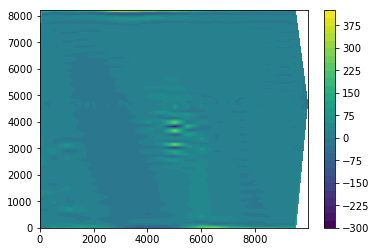

In [12]:
plt.tricontourf(yp, xp, eql[0].residuals(), 30)
plt.colorbar()

Now we can add our estimated magnetization to the layer. Fatiando requires magnetization to be specified as vectors. It provides a function in the `utils` module to convert intensity, inclination, and declination into (x, y, z) vectors.

In [13]:
from fatiando import utils

In [14]:
layer.addprop('magnetization', utils.ang2vec(eql.estimate_, inc, dec))

Now we forward model the anomaly using the layer on a regular grid at a constant height. 
The forward modeling is done by the `gravmag.sphere` module (point sources can be considered unit volume spheres).
Generating point distributions is done by the `gridder` module.

In [15]:
from fatiando.gravmag import sphere
from fatiando import gridder

In [16]:
shape = (85, 85)
x, y, z = gridder.regular(area, shape=shape, z=-700)

In [17]:
tfa_grid = sphere.tf(x, y, z, layer, inc, dec)

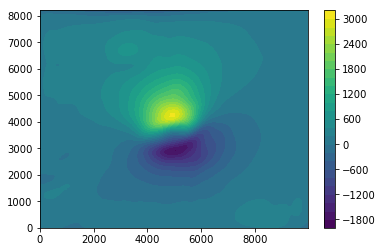

In [18]:
plt.tricontourf(y, x, tfa_grid, 30)
plt.colorbar()

## Transformations using the FFT

Now that we have data on a regular grid at uniform height we can use all the transformation functions in the `gravmag.transform` module.

In [19]:
from fatiando.gravmag import transform

First, the total gradient amplitude (a.k.a., the analytic signal).

In [20]:
tga = transform.tga(x, y, tfa_grid, shape)

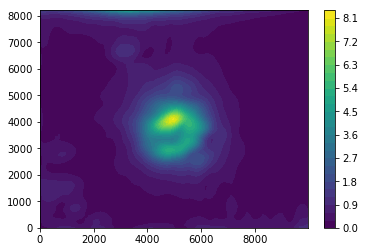

In [21]:
plt.tricontourf(y, x, tga, 30)
plt.colorbar()

We can also reduce to the pole. This requires the inclination and declination of the inducing geomagnetic field (`inc` and `dec`) **and** the inclination and declination of the sources magnetization (`sinc` and `sdec`). 
Since we don't know what the later is, we'll just assume that it's the same direction, i.e. there is only induced magnetization.

In [22]:
pole = transform.reduce_to_pole(x, y, tfa_grid, shape, inc, dec, sinc=inc, sdec=dec)

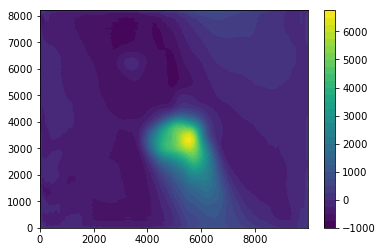

In [23]:
plt.tricontourf(y, x, pole, 30)
plt.colorbar()

That doesn't look right. The anomaly seems all stretched to the Southeast. This is a clear indication that there **isn't only induced magnetization**. 

## Estimating the magnetization direction

Fatiando implements a method for estimating the magnetization direction of approximately spherical bodies from the total field anomaly. This is in the `gravmag.magdir` module.
The method requires that we know approximately the coordinates of the center of the source.
We can estimate this using the Euler deconvolution method, assuming that our source is spherical (structural index of 3).

In [24]:
from fatiando.gravmag.euler import EulerDeconvEW
from fatiando.gravmag.magdir import DipoleMagDir

Euler deconvolution requires the x, y, z derivatives of the anomaly. We can calculate them using the `gravmag.transform` module.

In [25]:
dx = transform.derivx(x, y, tfa_grid, shape)
dy = transform.derivy(x, y, tfa_grid, shape)
dz = transform.derivz(x, y, tfa_grid, shape)

The Euler Deconvolution in Fatiando is a bit different from the one you'll find in most commercial software. 
We prefer to use an expanding window scheme rather than a moving window scheme (we have that one too if you want). 
The main difference is that the expanding window will give you a single solution instead of the many meaningless solutions of the moving window.

In [26]:
euler = EulerDeconvEW(x, y, z, tfa_grid, dx, dy, dz, structural_index=3, 
                      center=[4000, 5000], sizes=range(500, 8000, 500))

In [27]:
euler.fit()

The estimated (x, y, z) coorinates of the source are:

In [28]:
euler.estimate_

array([ 3684.09587513,  5253.60075365,   627.67749843])

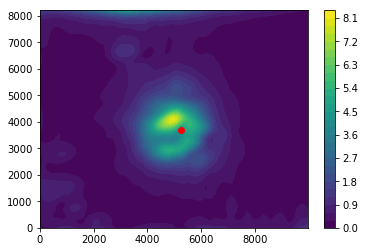

In [29]:
plt.tricontourf(y, x, tga, 30)
plt.colorbar()
plt.plot(euler.estimate_[1], euler.estimate_[0], 'ro')

Now we can use `DipoleMagDir` to estimate the magnetization direction. Notice that you can chain the creation of the object and the call to `fit()` to make the code smaller.

In [30]:
mag = DipoleMagDir(x, y, z, tfa_grid, inc, dec, [euler.estimate_]).fit()

The estimated intensity, inclination, and declination are:

In [31]:
mag.estimate_

[[6908.4450952485677, -63.578688588810586, -39.964109312998175]]

As a reminder, here are the inclination and declination of the geomagnetic field.

In [32]:
inc, dec

(-19.5, -18.5)

To test our estimate, we can use it to reduce to the pole and see what the results look like.

In [33]:
sinc, sdec = mag.estimate_[0][1:]

In [34]:
pole = transform.reduce_to_pole(x, y, tfa_grid, shape, inc, dec, sinc, sdec)

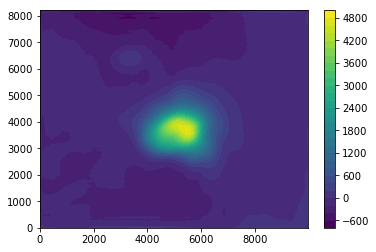

In [35]:
plt.tricontourf(y, x, pole, 30)
plt.colorbar()

Much better! So it seems likely that our estimate is correct. 

Now that we have the inclination and declination we could use it to do forward modeling or an inversion. 
Knowing the sources magnetization is crucial! You'll get completely wrong results if you use the wrong one. 
And you might not even notice because your wrong model will fit the data perfectly.